In [29]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3), 'x_train shape mismatch'
assert x_test.shape  == (10000, 32, 32, 3), 'x_test shape mismatch'
assert y_train.shape == (50000, 1),         'y_train shape mismatch'
assert y_test.shape  == (10000, 1),         'x_test shape mismatch'

classes = np.array([b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'])

170498071/170498071 [==============================] - 4s 0us/step


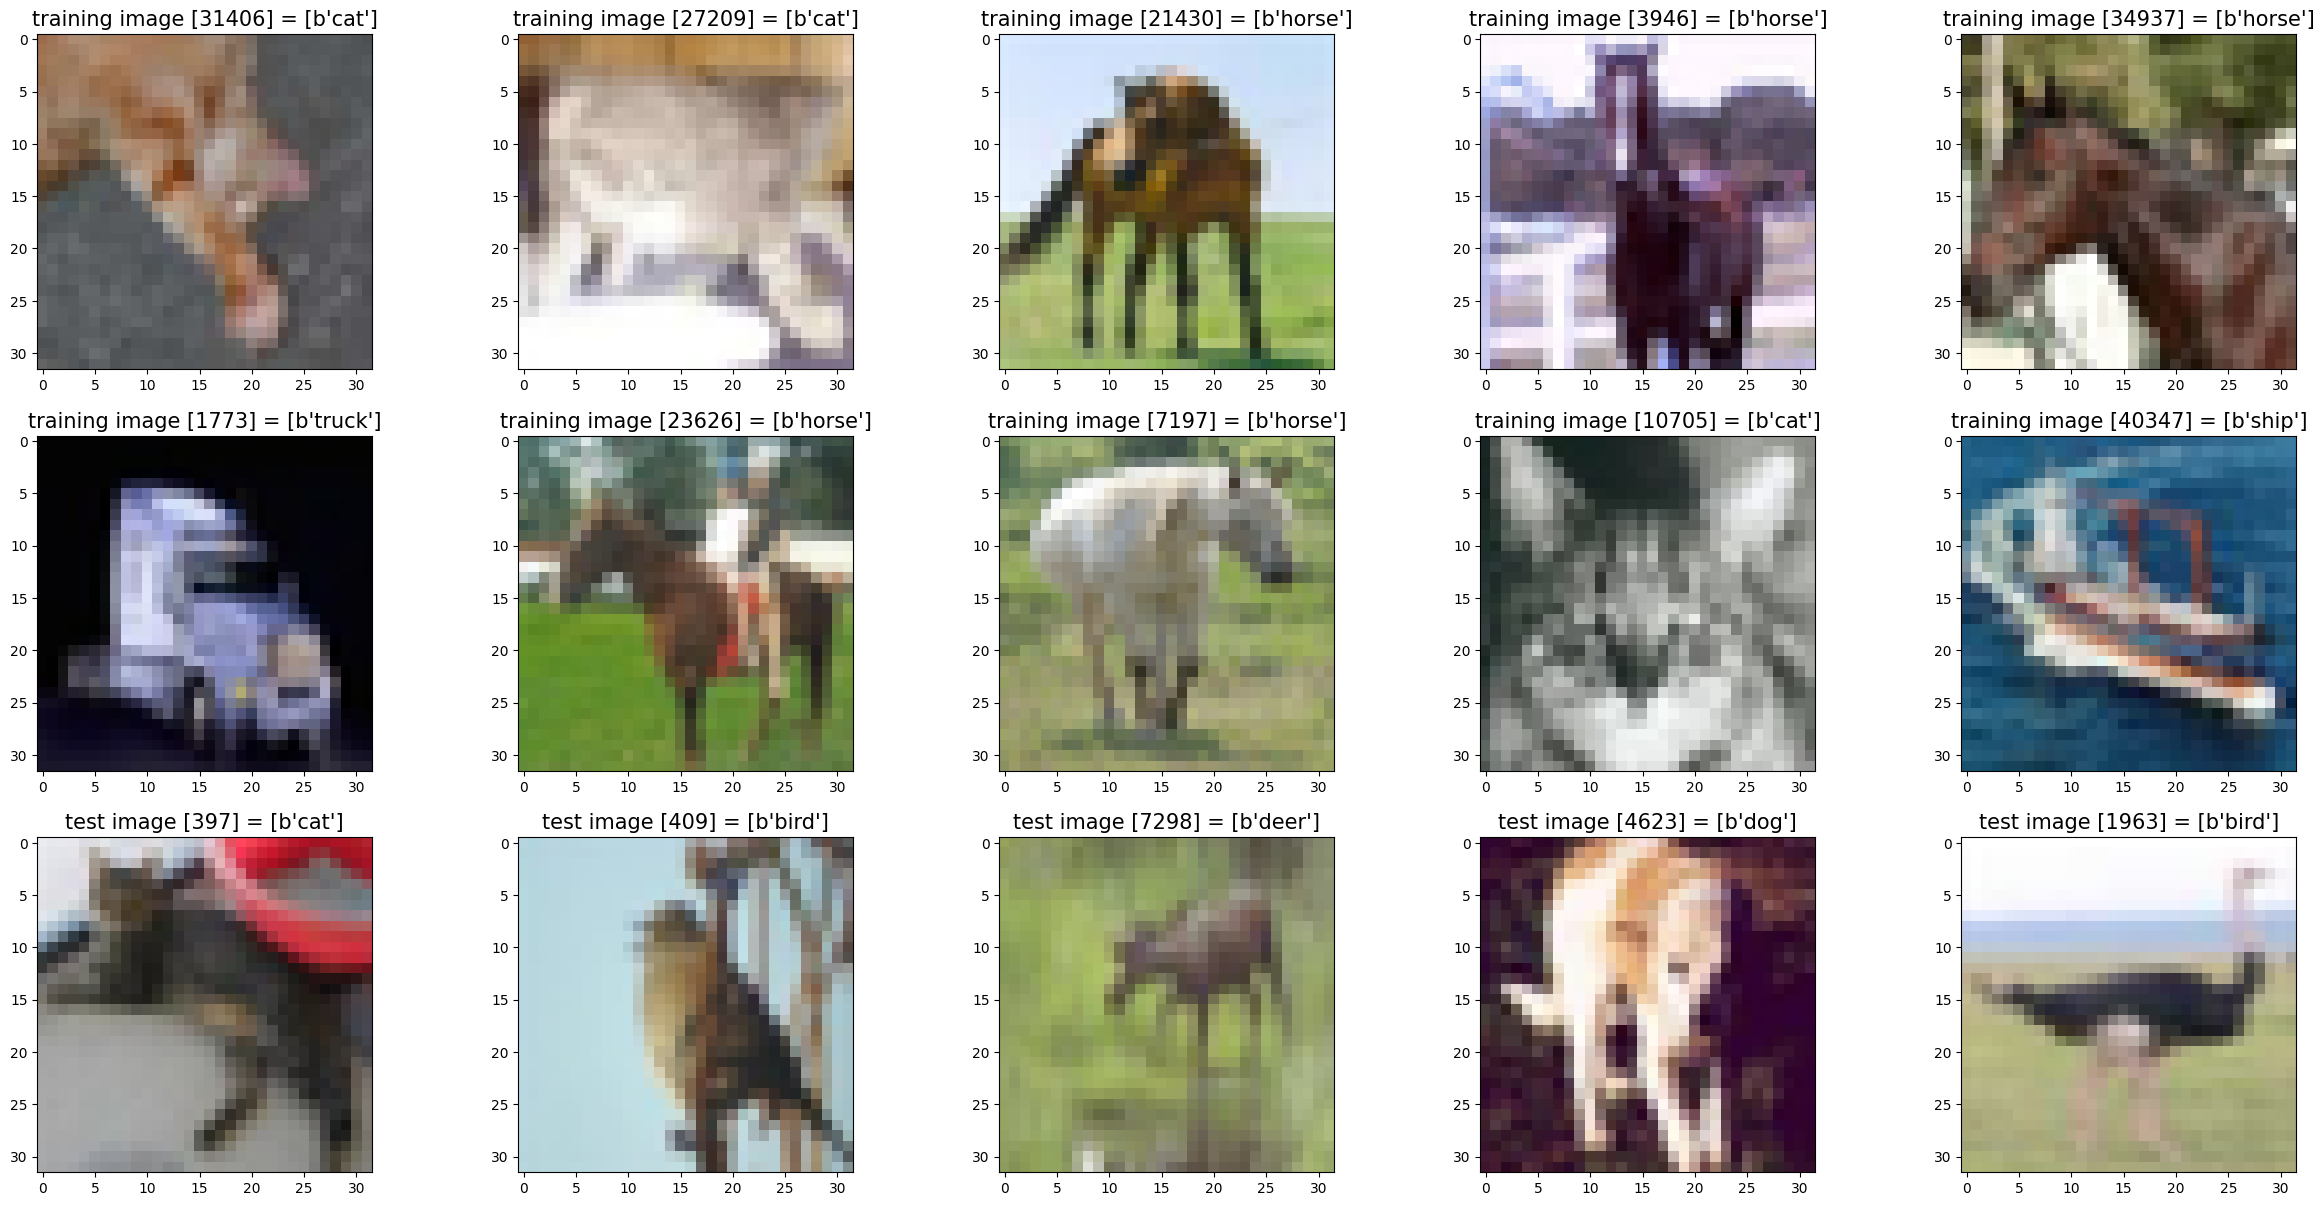

In [3]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 50000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(classes[y_train[r]]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(classes[y_test[r]]))

show_images(images_2_show, titles_2_show)

In [4]:
print("Available Physical Devices: ", tf.config.list_physical_devices())

Available Physical Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
LEARNING_RATE = 3e-4
DROPOUT_RATE = 0.3
REGULARIZATION = 1e-3

with tf.device('/GPU:0'):
  vgg = tf.keras.Sequential(layers=[
        tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),

        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Resizing(height=64, width=64),

        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),

        tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=64,  kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=REGULARIZATION)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=2048, activation='relu'),
        tf.keras.layers.Dropout(rate=DROPOUT_RATE),
        tf.keras.layers.Dense(units=2048, activation='relu'),
        tf.keras.layers.Dropout(rate=DROPOUT_RATE),
        tf.keras.layers.Dense(units=10)
  ])

vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                                                                            decay_steps=1000, decay_rate=0.95)),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 64, 64, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                        

In [6]:
checkpoint_filepath = './model_checkpoint'

history = vgg.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_split=0.25, callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                                                                                         save_weights_only=True,
                                                                                                                                         monitor='val_sparse_categorical_accuracy',
                                                                                                                                         mode='max',
                                                                                                                                         save_best_only=True)])

vgg.load_weights(checkpoint_filepath)

Epoch 1/100
293/293 [==============================] - 81s 212ms/step - loss: 5.3184 - sparse_categorical_accuracy: 0.3225 - val_loss: 6.7789 - val_sparse_categorical_accuracy: 0.0995
Epoch 2/100
293/293 [==============================] - 49s 168ms/step - loss: 3.9991 - sparse_categorical_accuracy: 0.4317 - val_loss: 3.8405 - val_sparse_categorical_accuracy: 0.3405
Epoch 3/100
293/293 [==============================] - 48s 165ms/step - loss: 3.1004 - sparse_categorical_accuracy: 0.5057 - val_loss: 2.6875 - val_sparse_categorical_accuracy: 0.5582
Epoch 4/100
293/293 [==============================] - 51s 174ms/step - loss: 2.5077 - sparse_categorical_accuracy: 0.5525 - val_loss: 2.2346 - val_sparse_categorical_accuracy: 0.5970
Epoch 5/100
293/293 [==============================] - 51s 173ms/step - loss: 2.1250 - sparse_categorical_accuracy: 0.5965 - val_loss: 1.9626 - val_sparse_categorical_accuracy: 0.6065
Epoch 6/100
293/293 [==============================] - 49s 167ms/step - loss: 1.

In [15]:
# ADDING ANOTHER 20 EPOCHS

checkpoint_filepath = './model_checkpoint'

history2 = vgg.fit(x=x_train, y=y_train, batch_size=128, epochs=20, validation_split=0.25, callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                                                                                          save_weights_only=True,
                                                                                                                                          monitor='val_sparse_categorical_accuracy',
                                                                                                                                          mode='max',
                                                                                                                                          save_best_only=True)])

vgg.load_weights(checkpoint_filepath)

Epoch 1/20
293/293 [==============================] - 47s 161ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.9498 - val_loss: 0.6144 - val_sparse_categorical_accuracy: 0.8890
Epoch 2/20
293/293 [==============================] - 48s 165ms/step - loss: 0.3772 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.5771 - val_sparse_categorical_accuracy: 0.9002
Epoch 3/20
293/293 [==============================] - 47s 160ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.5918 - val_sparse_categorical_accuracy: 0.8915
Epoch 4/20
293/293 [==============================] - 49s 166ms/step - loss: 0.3665 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.5819 - val_sparse_categorical_accuracy: 0.8973
Epoch 5/20
293/293 [==============================] - 48s 163ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.8925
Epoch 6/20
293/293 [==============================] - 48s 163ms/step - loss: 0.3611 -

In [21]:
for k in history2.history.keys():
    history.history[k].extend(history2.history[k])

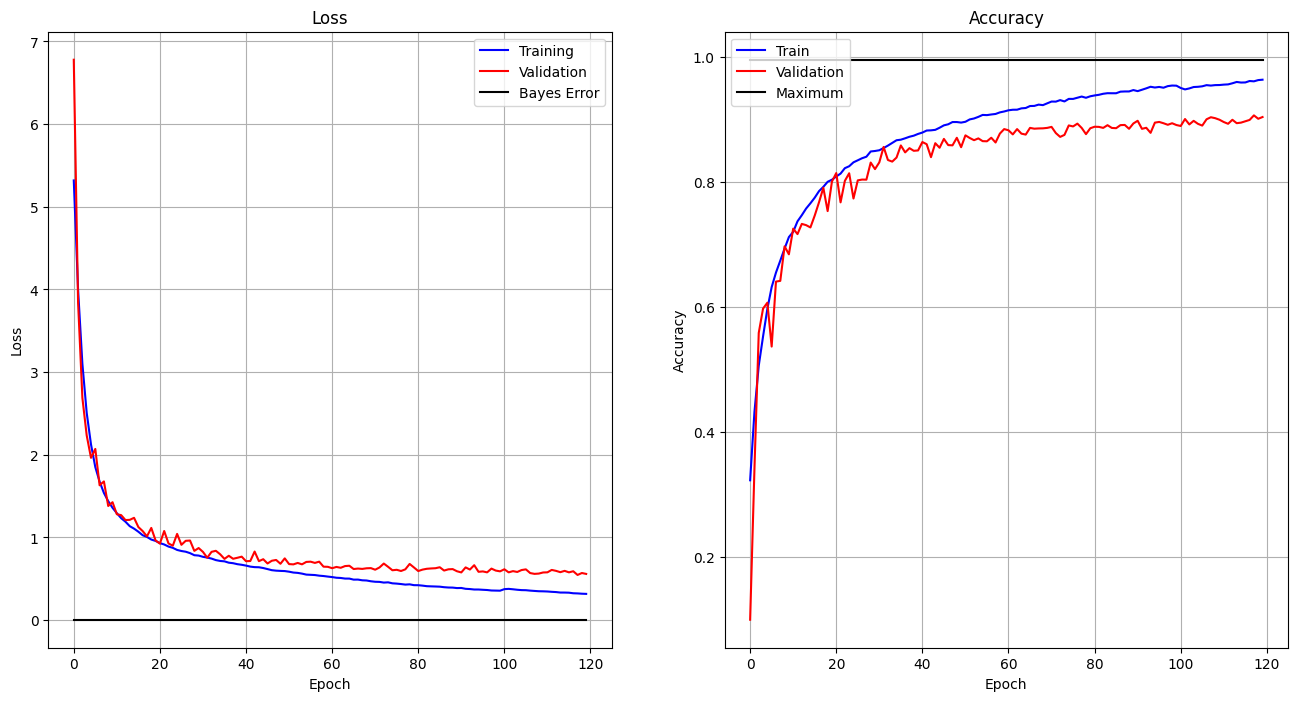

In [24]:
figure, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(history.history['loss'], color='b')
axes[0].plot(history.history['val_loss'], color='r')
axes[0].plot(np.full((120,), 0.004), color='k')
axes[0].set_title('Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid()
axes[0].legend(['Training', 'Validation', 'Bayes Error'], loc='upper right')

axes[1].plot(history.history['sparse_categorical_accuracy'], color='b')
axes[1].plot(history.history['val_sparse_categorical_accuracy'], color='r')
axes[1].plot(np.full((120,), 0.995), color='k')
axes[1].set_title('Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].grid()
axes[1].legend(['Train', 'Validation', 'Maximum'], loc='upper left')

plt.show()

In [25]:
accuracy = vgg.evaluate(x=x_test, y=y_test)[-1]*100
accuracy = accuracy - ((accuracy*100)%1)/100

print('\n\n\tAccuracy:\t', accuracy, '%')

313/313 [==============================] - 5s 15ms/step - loss: 0.5735 - sparse_categorical_accuracy: 0.9002


	Accuracy:	 90.02 %


In [31]:
y_test_pred_scores = vgg.predict(x_test)
y_test_pred = np.argmax(y_test_pred_scores, axis=-1)

313/313 [==============================] - 4s 13ms/step


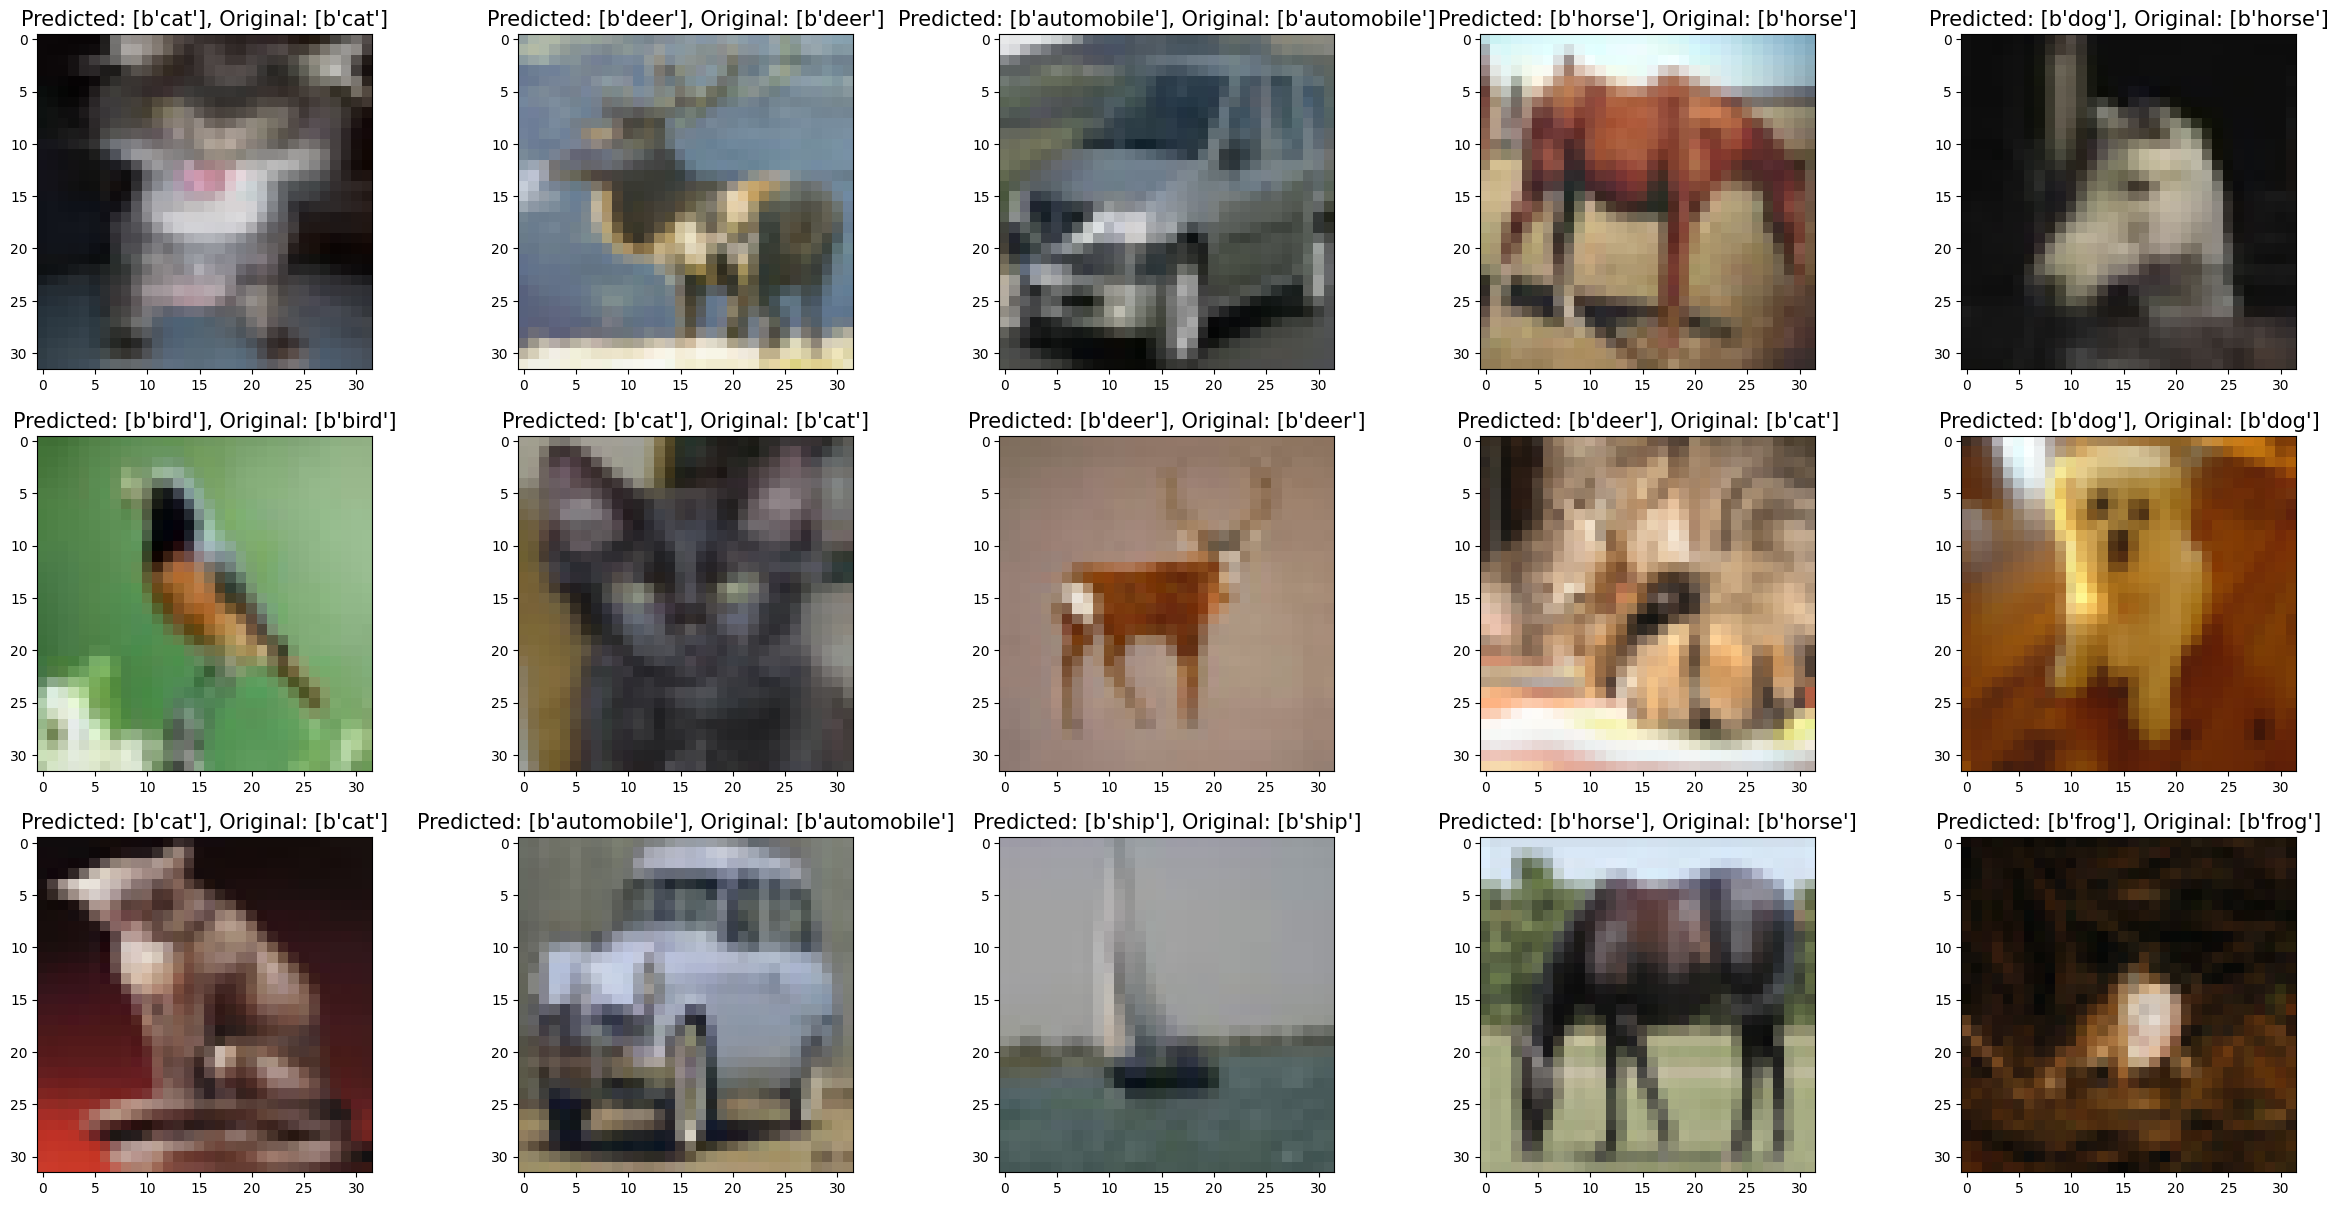

In [32]:
images_2_show = []
titles_2_show = []
for i in range(0, 15):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('Predicted: [' + str(classes[y_test_pred[r]]) + '], Original: ' + str(classes[y_test[r]]))

show_images(images_2_show, titles_2_show)

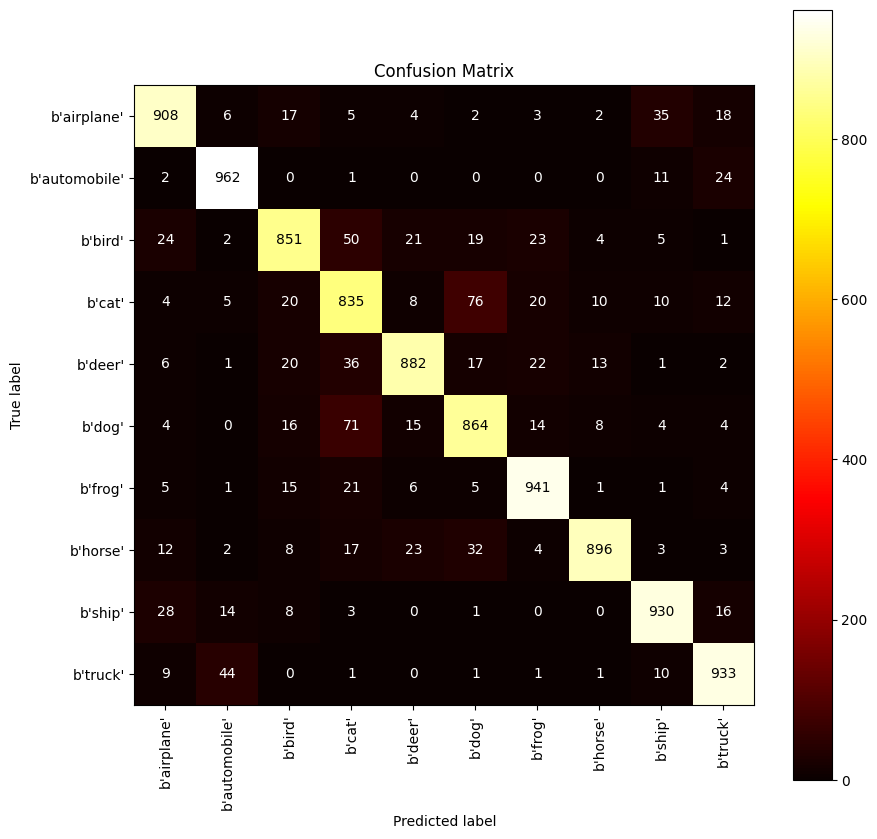

In [48]:
cnf = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cnf, cmap='hot', interpolation='nearest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
plt.xticks(np.arange(10), classes, rotation='vertical')
plt.yticks(np.arange(10), classes)

for i in range(10):
    for j in range(10):
        if i == j:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='black')
        else:
            plt.text(j, i, cnf[i, j], ha='center', va='center', color='white')

plt.title('Confusion Matrix')

plt.show()

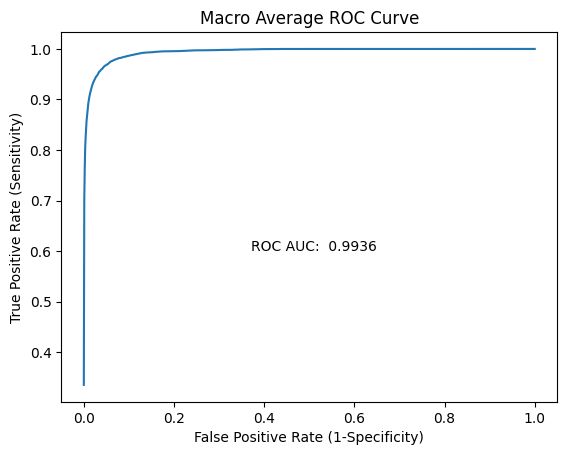

In [53]:
y_test_pred_scores = y_test_pred_scores.astype(np.float64)
y_softmax = np.exp(y_test_pred_scores) / np.sum(np.exp(y_test_pred_scores), axis=1, keepdims=True)
auc = roc_auc_score(y_test, y_softmax, average='weighted', multi_class='ovr')

fpr = dict()
tpr = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_softmax[:, i], pos_label=i)

fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(10):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= 10

plt.plot(fpr_grid, mean_tpr)
plt.title('Macro Average ROC Curve')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.text(0.37, 0.6, 'ROC AUC:  '+str(auc - ((auc*10000)%1)/10000))

plt.show()

In [54]:
vgg.save('../content/VGG-16.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(vgg)
tflite_model = converter.convert()
open("VGG-16.tflite", "wb").write(tflite_model)

92536696